In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



In [4]:
data = pd.read_excel('/content/drive/MyDrive/DataSet/yahoo_data.xlsx')

data.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Apr 28, 2023",33797.43,34104.56,33728.40,34098.16,34098.16,354310000
1,"Apr 27, 2023",33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2,"Apr 26, 2023",33596.34,33645.83,33235.85,33301.87,33301.87,321170000
3,"Apr 25, 2023",33828.34,33875.49,33525.39,33530.83,33530.83,297880000
4,"Apr 24, 2023",33805.04,33891.15,33726.09,33875.40,33875.40,252020000


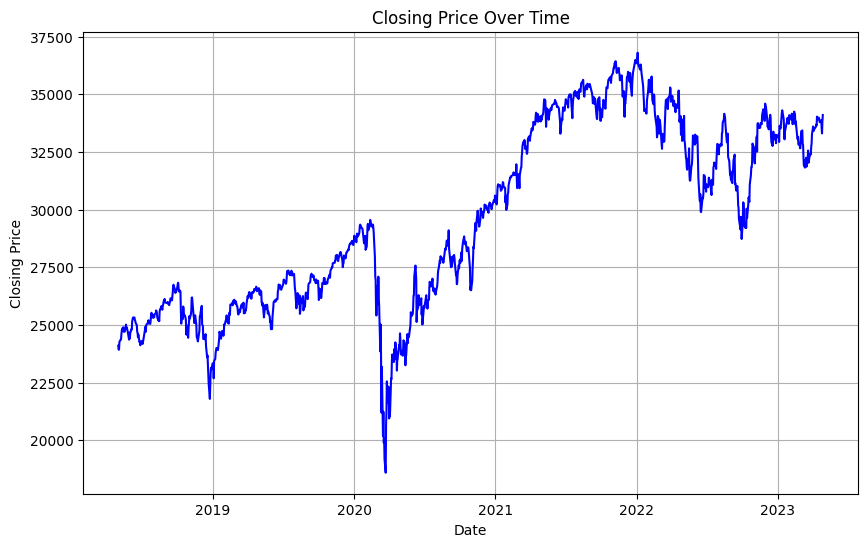

In [5]:
data['Date'] = pd.to_datetime(data['Date'])

plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Close*'], color='blue')
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

In [6]:
null_values = data.isnull().sum()
print(null_values)

Date           0
Open           0
High           0
Low            0
Close*         0
Adj Close**    0
Volume         0
dtype: int64


In [7]:
column_names = data.columns
column_names

Index(['Date', 'Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume'], dtype='object')

In [8]:
data['Date'] = pd.to_datetime(data['Date'])

In [9]:
data['SMA_20'] = data['Close*'].rolling(window=20).mean()

data['EMA_20'] = data['Close*'].ewm(span=20, adjust=False).mean()

delta = data['Close*'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))

data['BB_upper'] = data['SMA_20'] + 2 * data['Close*'].rolling(window=20).std()
data['BB_lower'] = data['SMA_20'] - 2 * data['Close*'].rolling(window=20).std()

data.tail()

,Date,Open,High,Low,Close*,Adj Close**,Volume,SMA_20,EMA_20,RSI_14,BB_upper,BB_lower
1253,2018-05-07,24317.66,24479.45,24263.42,24357.32,24357.32,307670000,24691.3960,24700.034050,36.954386,25075.253378,24307.538622
1254,2018-05-04,23865.22,24333.35,23778.87,24262.51,24262.51,329480000,24663.8370,24658.365093,32.316598,25087.776723,24239.897277
1255,2018-05-03,23836.23,23996.15,23531.31,23930.15,23930.15,389240000,24628.5840,24589.011275,23.577600,25164.909677,24092.258323
1256,2018-05-02,24097.63,24185.52,23886.30,23924.98,23924.98,385350000,24604.0410,24525.770201,24.209201,25220.322933,23987.759067
1257,2018-05-01,24117.29,24117.29,23808.19,24099.05,24099.05,380070000,24575.6045,24485.130182,24.001865,25230.761663,23920.447337


In [10]:
features_for_anomaly = data[['Close*', 'SMA_20', 'EMA_20', 'RSI_14']].dropna()

iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_labels = iso_forest.fit_predict(features_for_anomaly)

data = data.iloc[-features_for_anomaly.shape[0]:]
data['Anomaly'] = anomaly_labels

print(data['Anomaly'].value_counts())

Anomaly
 1    1177
-1      62
Name: count, dtype: int64


<ipython-input-10-8a48d093378f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Anomaly'] = anomaly_labels


In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Adj Close**', 'Volume', 'Close*']])

X = scaled_data[:, :-1]
y = scaled_data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, batch_size=64)

loss = model.evaluate(X_test, y_test)

predictions = model.predict(X_test)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2595
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0194
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1280e-04
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9572e-04
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3237e-04
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1871e-04
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9862e-04
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1380e-04
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5716e-04
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1377e-04
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.093

In [13]:
r_squared = r2_score(y_test, predictions)
print("R-squared:", r_squared)

R-squared: 0.9960669734504293


In [14]:
predictions = predictions.reshape(-1, 1)

print("Shape of y_test:", y_test.shape)
print("Shape of predictions:", predictions.shape)

Shape of y_test: (248,)
Shape of predictions: (248, 1)


In [15]:
mse = mean_squared_error(y_test, predictions)

rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.00018375185777989508
Root Mean Squared Error (RMSE): 0.013555510236796514


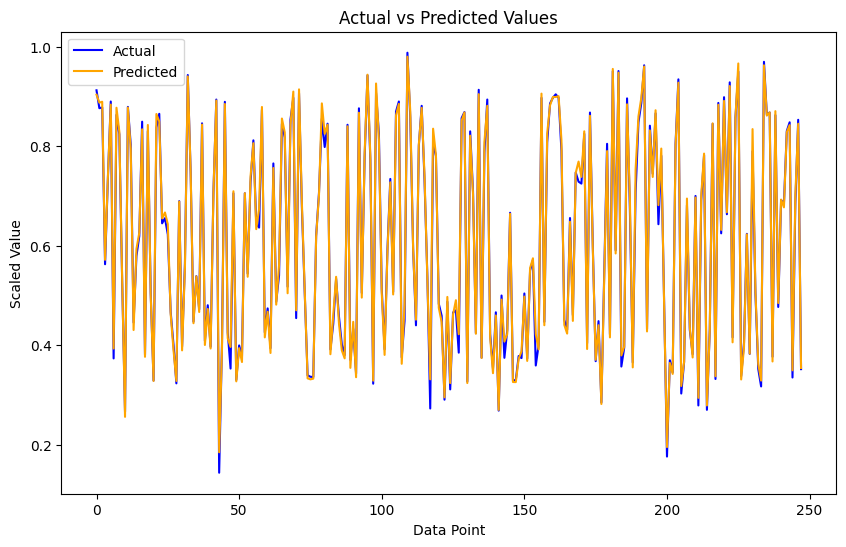

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='orange')
plt.title('Actual vs Predicted Values')
plt.xlabel('Data Point')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

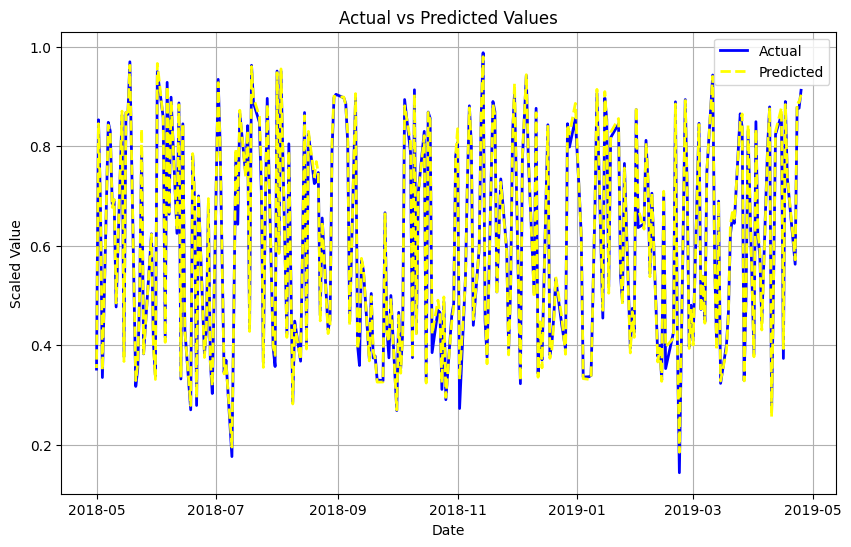

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(data['Date'][len(X_train):], y_test, label='Actual', color='blue', linewidth=2)
plt.plot(data['Date'][len(X_train):], predictions, label='Predicted', color='yellow', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.show()

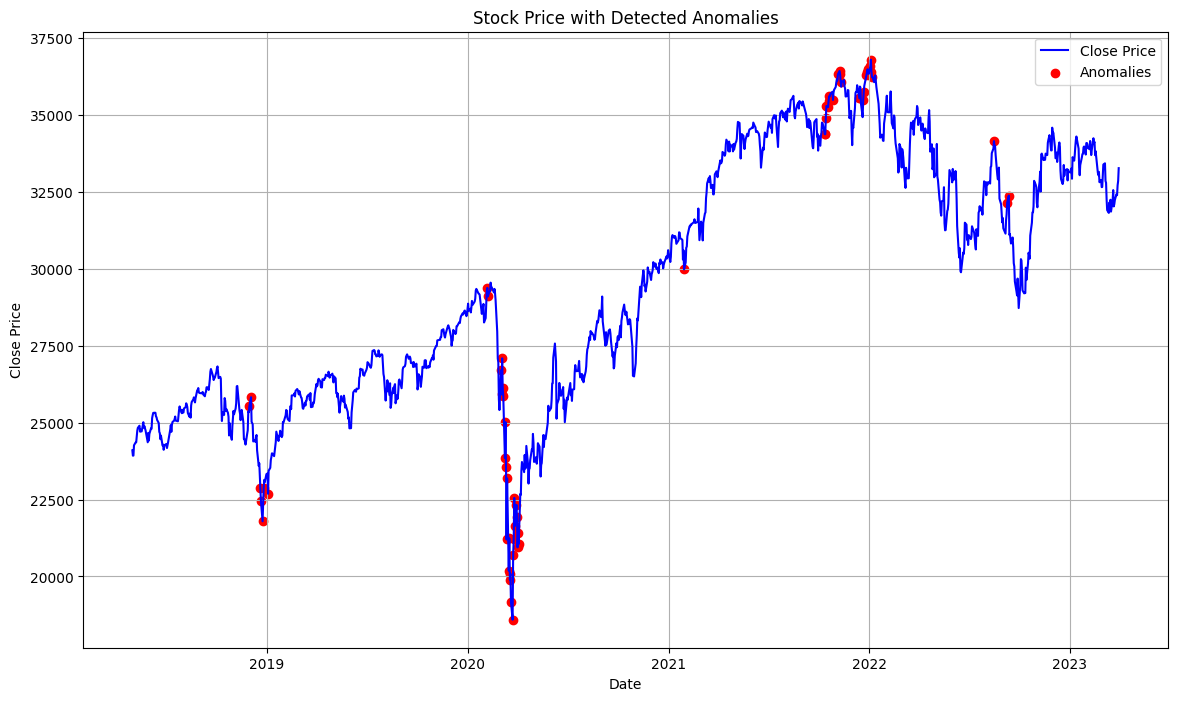

In [18]:
plt.figure(figsize=(14, 8))
plt.plot(data['Date'], data['Close*'], label='Close Price', color='blue')

anomalies = data[data['Anomaly'] == -1]
plt.scatter(anomalies['Date'], anomalies['Close*'], color='red', label='Anomalies', marker='o')

plt.title('Stock Price with Detected Anomalies')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()
